# Analyse channel 1 - 4
Here I will analyse the data of channel 1 - 4 from Alsdorf

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import numpy as np
import matplotlib.dates as mdates
from scipy import optimize
import matplotlib.patches as patches
from collections import defaultdict
from datetime import timedelta
from datetime import datetime
import pickle
from ipywidgets import interact
import ipywidgets as widgets
from copy import deepcopy#, copy
import statistics
#from random import randrange
from bokeh.io import export_png, export_svgs
from bokeh.models import ColumnDataSource, DataTable, TableColumn
from shutil import copy2 as copy_file
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.fft import fft, fftfreq, rfft, rfftfreq, irfft

import plotly
import plotly.express as px
import kaleido

from my_func_mvw.functions_import_my_database import import_my_database_pickle, import_my_database_csv, merge_data_year
from my_func_mvw.functions import find_nearest_date, watertank_shift, calc_diff_between_channels, read_pickle, write_pickle, temp_watertank_func, check_first_last_date, calc_stat_of_difference, cut_dataframe_to_range_tlogger, check_processed_data, carpet_plot_with_gaps, add_nan_val_in_datagaps, statistic_plot, plot_water_rise, diff_to_watertank
from my_func_mvw.fourier_transform_func import resample_data_func, plot_frequency_spectrum, fourier_transform
%load_ext autoreload
%autoreload 2

plot_save=True #True False
fast_calc=False #True False

path_to_my_database = r"..\Alsdorf\Daten\my_database" #".\\"
importer = "pickle" #at the moment everything is imported with pickle

# TO DO
# andere kalibrationsmethoden offenes ende --> Literatur lesen
# knick in dämpfung noch bearbeiten
# Vergleich mit anderen Kanälen systematisch machen

print("Some Version information of the imported packages")
print(f"pandas version: {pd.__version__}")
print(f"pickle version: {pickle.format_version}")
# pandas version: 1.2.3
# pickle version: 4.0

Some Version information of the imported packages
pandas version: 1.3.4
pickle version: 4.0


In [2]:
# Load pickle Data

#if using all data this variable is over 2Gb.
data_ch14_constshifted = read_pickle(path_to_my_database + "\..\my_database_additional_local\data_ch1-4_processed_constshifted")


if fast_calc:
    for chan in ["1","2","3","4"]:
        data_ch14_constshifted[chan] = data_ch14_constshifted[chan][::10] #only use every 10th row

# final shaft temp old cable
shaft={}
for chan in ["1","2","3","4"]:
    shaft[chan] = read_pickle(path_to_my_database + f"\\shaft_final_temperature\\old_cable\\pickle\\Schacht_chan_{chan}")

# final shaft temp egrt cabel
filename=f"\\Schacht_7and8_down"
path_to_my_database_pickle = path_to_my_database + r"\shaft_final_temperature\egrt_cable\pickle"
Schacht_7and8_down = read_pickle(path_to_my_database_pickle + filename)

# Import TLogger
Im Moment sind im PT100 Datensatz alle Daten die ich habe. D.h. meine alten PT100 um 1.5 °C korigiert, ein paar Daten von Solexperts und die neuen PT1000 Daten.

In [3]:
# read csv
# Tlogger_PT1000 = pd.read_csv(path_to_my_database + "\\t_logger_watertank\\Tlogger_PT1000.csv", index_col=[0])
# Tlogger_PT100  = pd.read_csv(path_to_my_database + "\\t_logger_watertank\\Tlogger_PT100_outdated.csv",index_col=[0])
# Tlogger_PT100.index.names=["Date"]; Tlogger_PT1000.index.names=["Date"]
# Tlogger_PT100.index = pd.to_datetime(Tlogger_PT100.index); Tlogger_PT1000.index = pd.to_datetime(Tlogger_PT1000.index)

#read_pickle
df_Tlogger_PT1000 = read_pickle(path_to_my_database + "\\t_logger_watertank\\Tlogger_PT1000")
df_Tlogger_PT100  = read_pickle(path_to_my_database + "\\t_logger_watertank\\Tlogger_PT100_outdated")

watertank_T_range_min = df_Tlogger_PT100.index.min()
watertank_T_range_max = df_Tlogger_PT100.index.max()

df_Tlogger_PT100

Channel1-Watertank_PT100  Channel2-Air  \
2021-06-07 12:12:40                      23.4          25.8   
2021-06-07 12:13:40                      23.5          25.4   
2021-06-07 12:14:40                      23.4          25.2   
2021-06-07 12:15:40                      23.5          24.9   
2021-06-07 12:16:40                      23.5          24.8   
...                                       ...           ...   
2021-10-06 10:49:47                      17.7           NaN   
2021-10-06 10:52:47                      17.7           NaN   
2021-10-06 10:55:47                      17.7           NaN   
2021-10-06 10:58:47                      17.7           NaN   
2021-10-06 11:01:47                      17.7           NaN   

                     Channel1-PT100_rolling_mean  
2021-06-07 12:12:40                         23.5  
2021-06-07 12:13:40                         23.5  
2021-06-07 12:14:40                         23.5  
2021-06-07 12:15:40                         23.5  
2021-06-07 12:16:40                         23.5  
...                                          ...  
2021-10-06 10:49:47                         17.7  
2021-10-06 10:52:47                         17.7  
2021-10-06 10:55:47                         17.7  
2021-10-06 10:58:47                         17.7  
2021-10-06 11:01:47                         17.7  

[62805 rows x 3 columns]

In [4]:
# calc diff to watertank

watertank_T_range_min=df_Tlogger_PT100.index[0]
watertank_T_range_max=df_Tlogger_PT100.index[-1]
watertank_diff_log_data_all=diff_to_watertank(cut_dataframe_to_range_tlogger(["1","2","3","4"],data_ch14_constshifted,watertank_T_range_min,watertank_T_range_max),
                                                    df_Tlogger_PT100=df_Tlogger_PT100,watertank_len=[71],watertank_T_range_min=watertank_T_range_min,watertank_T_range_max=watertank_T_range_max)


Channel: 1; Number of dates: 5554
first (oldes) date: 2021-06-07 12:12:22
last (newest) date: 2021-10-06 10:14:50

Channel: 2; Number of dates: 5554
first (oldes) date: 2021-06-07 12:16:22
last (newest) date: 2021-10-06 10:18:50

Channel: 3; Number of dates: 5554
first (oldes) date: 2021-06-07 12:20:22
last (newest) date: 2021-10-06 10:22:50

Channel: 4; Number of dates: 5554
first (oldes) date: 2021-06-07 12:24:22
last (newest) date: 2021-10-06 10:26:50


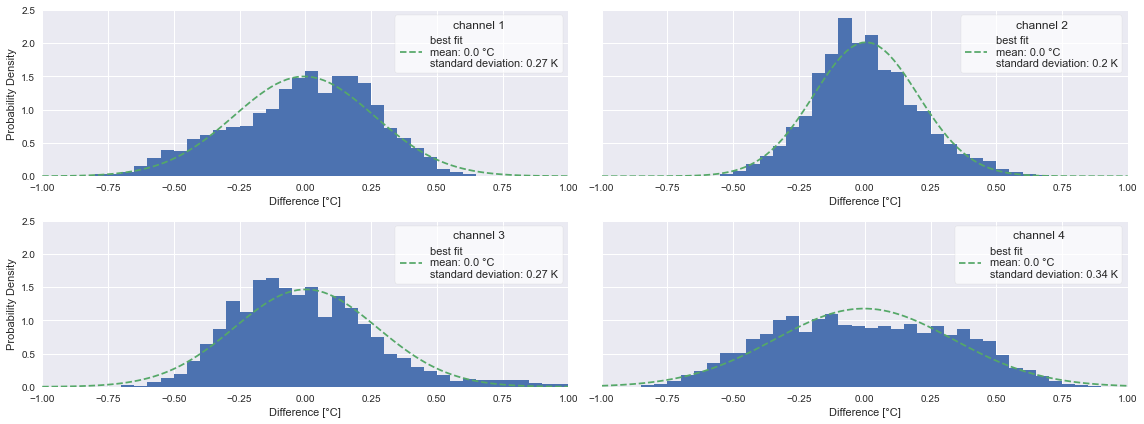

In [5]:
#differenced at first watertank position of processed data to reference temp
def plt_hist_in_axs(data,ax,num_bins=30,binwidth=0.05):
    """"""
    mean=data.mean()
    stdv=data.std()

    # n, bins, patches = ax.hist(data, num_bins, density=True) #uses number of bins
    n, bins, patches = ax.hist(data,bins=np.arange(-1, 1 + binwidth, binwidth), density=True) #uses a binwidth
    from scipy.stats import norm
    x = np.linspace(-1, 1, 100)
    ax.plot(x, norm.pdf(x, mean, stdv),linestyle="--",label=f"best fit\nmean: 0.0 °C\nstandard deviation: {round(stdv,2)} K")


    #Alternative plotting ways:
    # weights = np.ones_like(data)/float(len(data))
    # n, bins, patches =ax.hist(data, weights=weights)

    # y=((1 / (np.sqrt(2 * np.pi) * stdv)) * np.exp(-0.5 * (1 / stdv * (bins - mean))**2)) #best fit
    # ax.plot(bins, y, '--', label=f"best fit\nmean: 0.0 °C\nstandard deviation: {round(stdv,2)} K")

fig,axs=plt.subplots(2,2,figsize=(16,6),sharey=True,tight_layout=True)
axes_tuples=[[0,0],[0,1],[1,0],[1,1]]
axes_counter=0
for chan in ["1","2","3","4"]:
    ax=axs[axes_tuples[axes_counter][0]][axes_tuples[axes_counter][1]]
    plt_hist_in_axs(watertank_diff_log_data_all[chan].loc[71],ax)

    # Acessoirs
    legend=ax.legend(fontsize=11, frameon=True,title_fontsize=12,title=f"channel {chan}")
    legend.get_frame().set_alpha(0.7) #not supported with eps
    legend.get_frame().set_facecolor("white")
    ax.set_ylim(0,2.5)
    ax.set_xlim(-1,1)
    ax.set_xlabel("Difference [°C]")
    axes_counter+=1

axs[0,0].set_ylabel("Probability Density")
axs[1,0].set_ylabel("Probability Density")

if plot_save:
    plt.savefig("pictures\diff_to_first_watertanl_probability_ch14.png",bbox_inches="tight")
    plt.savefig(r"..\Masterthesis_tex\figs\chap4\diff_to_first_watertanl_probability_ch14.pdf", format="pdf",bbox_inches="tight")
plt.show()

In [6]:
# difference between the channels has a higher standard deviation than the difference to the reference temperature
show_diff_in_watertank_between_channels=False
if show_diff_in_watertank_between_channels:
    test=cut_dataframe_to_range_tlogger(["1","2","3","4"],data_ch14_constshifted,watertank_T_range_min,watertank_T_range_max)

    test_diff=test["1"][71].values - test["4"][71].values

    binwidth=0.05
    n, bins, patches = plt.hist(test_diff,bins=np.arange(-1, 1 + binwidth, binwidth), density=True) #uses a binwidth
    mean=test_diff.mean()
    stdv=test_diff.std()
    from scipy.stats import norm
    x = np.linspace(-1, 1, 100)
    plt.plot(x, norm.pdf(x, mean, stdv),linestyle="--",label=f"best fit\nmean: 0.0 °C\nstandard deviation: {round(stdv,2)} K")
    plt.legend()
    plt.show()

# Compare BHE Cable channel 1 - 4 to Wireline T-Logger 2020

In [7]:
# Load Wireline data
path_to_wireline = path_to_my_database + "\PTS_Logs"

filename2003=r"\PTS_2003.csv"
wireline_measurements2003 = pd.read_csv(path_to_wireline + filename2003,skiprows=[0,2,3],index_col=0,na_values=-999.0)
wireline_measurements2003.columns = ["BHT","CBLE_ACC","CURRENT","DIFF-TENSION0","GAMMA","MEASURERANGE","PRESS","SAL","SPEED","TENSION","TIME","VOLTAGE"] #rename columns, because the original names contain empty spaces
wireline_measurements2003 = wireline_measurements2003.dropna()

filename2020=r"\PTS_20201124.csv"
wireline_measurements2020 = pd.read_csv(path_to_wireline + filename2020,index_col=0,skiprows=[0,2,3],na_values=-999.0)
wireline_measurements2020.columns = ["BHT","DEPTH.1","dPress","GAMMA","MEASURERANGE","PRESS","SAL","SPEED","TENSION","TIME"]
wireline_measurements2020 = wireline_measurements2020.drop(columns=["DEPTH.1"]) # the same as DEPTH column
wireline_measurements2020 = wireline_measurements2020.dropna() # drop some nan rows

42785
42784
42784
42784


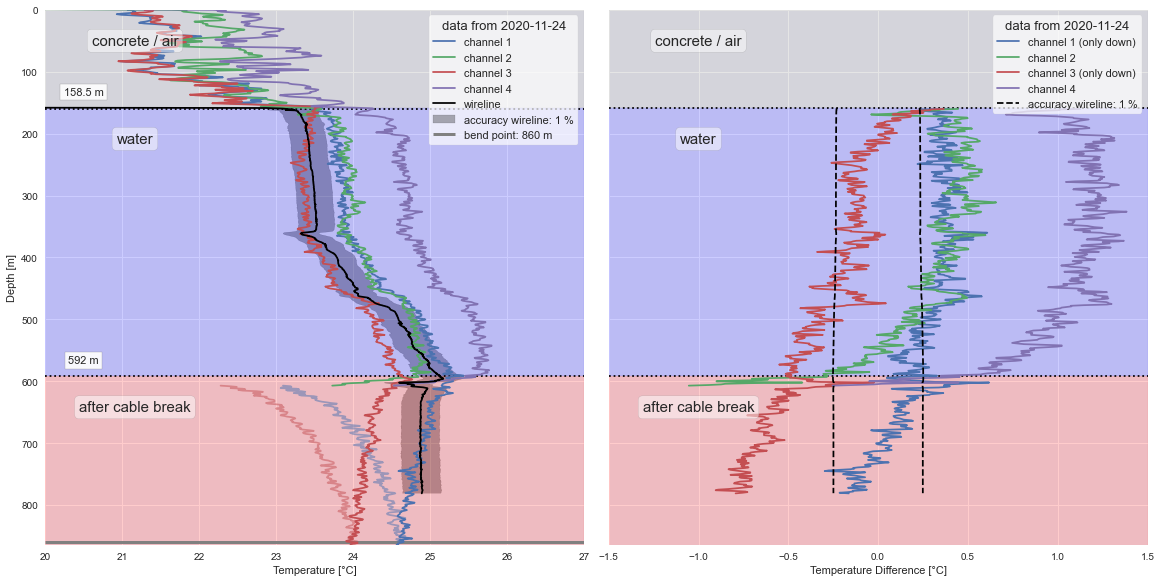

In [8]:
## INPUT
average_multiple_data=6 #number of dates to average; 0 for noe averageing; e.g. 5 results in average of 11 dates
border_dts_not_trusted=592
string_dts_not_trusted="after cable break"
#############

# Calc diff to wireline
diff_to_wireline = {}
last_wireline_depth=wireline_measurements2020["BHT"][160:][::20].index.max()
shaft_data = pd.DataFrame(index=np.arange(160,last_wireline_depth+1,1),columns=["dts chan 1","dts chan 2","dts chan 3","dts chan 4","wireline"])
shaft_data.index.names=["Depth"]

shaft_data["wireline"] = wireline_measurements2020["BHT"][160:][::20].values #skip air, only use datapoints every meter
for chan in ["1","2","3","4"]:
    date_name, date_iloc = find_nearest_date("2020-11-24 12:00:00",data_ch14_constshifted[chan].index)
    print(date_iloc)
    if average_multiple_data!=0:
        ilocs=np.arange(date_iloc-average_multiple_data,date_iloc+average_multiple_data+1,1)
    
    if chan in ["1","3"]:
        if average_multiple_data==0:
            data_ch = data_ch14_constshifted[chan].loc[date_name][200+160: int(last_wireline_depth)+201] #skip first 200 and air
        elif average_multiple_data!=0:
            data_ch=pd.concat([data_ch14_constshifted[chan].iloc[x][200+160: int(last_wireline_depth)+201] for x in ilocs], axis=1).mean(axis=1).round(2)
        shaft_data[f"dts chan {chan}"]= data_ch.values
    
    elif chan in ["2","4"]:
        index=data_ch14_constshifted[chan].loc[date_name][200+160:].index-200 #index shifted to shaft
        nanarray=np.empty((int(last_wireline_depth-index.max())))
        nanarray[:]=np.nan
        if average_multiple_data==0:
            data_ch=np.append(data_ch14_constshifted[chan].loc[date_name][200+160:],nanarray) #skip first 200 and air; add nan so length fits to wireline
        elif average_multiple_data!=0:
            data_ch=pd.concat([data_ch14_constshifted[chan].iloc[x][200+160:] for x in ilocs], axis=1).mean(axis=1).round(2)
            data_ch=np.append(data_ch.values,nanarray)
        shaft_data[f"dts chan {chan}"] = data_ch

    diff_to_wireline[chan] = shaft_data[f"dts chan {chan}"] - shaft_data["wireline"]

# PLOT: compare shifted data to wireline
def color_cable_pos(start_len, end_len, col, ymax, ymin, label_name, axs, label=True):
    """ creates patches which color the plot"""
    width = end_len - start_len
    Rectangle=patches.Rectangle(xy=[start_len,ymin],width=width,height=(ymax-ymin),color=col,alpha=0.2)
    axs.add_patch(Rectangle)
    if label:
        #axs.annotate(label_name,[start_len+width/2, ymax-(ymax-ymin)*0.9],size=15)
        bbox_props=dict(boxstyle="round",fc="white", ec="0.5", alpha=0.5)
        axs.text(start_len+width/6,ymin+50,label_name,ha="center",va="center",size=15,bbox=bbox_props)

begin_shaft = 200 # muss ich noch genauer nachgucken
water_table_depth=158.5
fig, axs = plt.subplots(1,2,figsize=[16,8],sharey=True)
fig.tight_layout()

#axs[0].set_title("Wireline 2020 and Corrected DTS", fontsize = 14)
axs[0].set_xlabel("Temperature [°C]")
templim=[20,27]
axs[0].set_xlim(templim)
for chan in ["1","2","3","4"]:
    date_name, date_iloc = find_nearest_date("2020-11-24 12:00:00",data_ch14_constshifted[chan].index)
    if average_multiple_data==0:
        data=data_ch14_constshifted[chan].loc[date_name]
    elif average_multiple_data!=0:
        ilocs=np.arange(date_iloc-average_multiple_data,date_iloc+average_multiple_data+1,1)
        data= pd.concat([data_ch14_constshifted[chan].iloc[x] for x in ilocs], axis=1).mean(axis=1).round(2)
    templine,=axs[0].plot(data.values, data.index - begin_shaft,
                label=f"channel {chan}") #\nTime: {date_name[11:-3]}

    # plot channels 1 and 3 at bend point back so they fit to shaft depth
    # bend point should be checked, if it fits to vertical line!
    if chan in ["1","3"]:
        bend_p=begin_shaft + 860
        data_after_bendpoint = data[bend_p:]
        new_index=np.arange(bend_p,bend_p-len(data_after_bendpoint.index),-1)
        data_after_bendpoint.index = new_index
        axs[0].plot(data_after_bendpoint.values, data_after_bendpoint.index - begin_shaft,color=templine.get_color(), alpha=0.5)
                #label=f"Channel {chan}\nfiber going up")


axs[0].plot(wireline_measurements2020["BHT"].values, wireline_measurements2020["BHT"].index,label="wireline",color="black")
data=wireline_measurements2020["BHT"][::20] #original dataframe has every 5 cm a datapoint, 1 m is sufficient
axs[0].fill_betweenx(data.index,data.values+0.01*data.values,data.values-0.01*data.values,color="black",alpha=0.3, 
                    label="accuracy wireline: 1 %")
# #color plot
axs[0].hlines([160,border_dts_not_trusted],templim[0],templim[1],color="black",linestyle=":")
bbox_props = dict(boxstyle="square", fc="w", ec="0.5", alpha=0.9)
size=11; y=50; ha="center"; va="center"
axs[0].text(templim[0]+0.5,border_dts_not_trusted -26,f"{border_dts_not_trusted} m", ha=ha, va=va, size=size, bbox=bbox_props)
axs[0].text(templim[0]+0.5,water_table_depth -26,"158.5 m", ha=ha, va=va, size=size, bbox=bbox_props)
color_cable_pos(templim[0],templim[1],"red",1150,border_dts_not_trusted,f"{string_dts_not_trusted}",axs[0])
color_cable_pos(templim[0],templim[1],"gray",water_table_depth,0,"concrete / air",axs[0])
color_cable_pos(templim[0],templim[1],"blue",border_dts_not_trusted,water_table_depth,"water",axs[0])

# # Bend point
last_length={}
for channel in ["1","2","3","4"]:
    col=data_ch14_constshifted[channel].columns[begin_shaft:]
    last_length[channel] = data_ch14_constshifted[channel][col].columns.max() - begin_shaft
    #print(f"Channel {channel} shifted, last length {last_length[channel]}")
    #passt ziemlich genau zur Einbautiefe der Erdwärmesonde
bend_point=last_length["2"] + (last_length["1"] - last_length["2"]) / 2 
axs[0].hlines([bend_point],templim[0],templim[1],color="grey",label=f"bend point: {int(bend_point)} m", linewidth=3)

#####################################################################################

axs[1].set_xlabel("Temperature Difference [°C]")
#axs[1].set_title("Difference DTS - Wireline", fontsize = 14)
difflim=[-1.5,1.5]
axs[1].set_xlim(difflim)
for chan in ["1","2","3","4"]:
    label_addon=""
    if chan in ["1","3"]:
        label_addon=" (only down)"
    axs[1].plot(diff_to_wireline[chan].values,diff_to_wireline[chan].index,label=f"channel {chan}{label_addon}")
data=wireline_measurements2020["BHT"][::20][water_table_depth:]
axs[1].plot(0.01*data.values,data.index,color="black",linestyle="--", label="accuracy wireline: 1 %")
axs[1].plot(-0.01*data.values,data.index,color="black",linestyle="--")
#color plot
axs[1].hlines([water_table_depth,border_dts_not_trusted],difflim[0],difflim[1],color="black",linestyle=":") #0
#bbox_props = dict(boxstyle="square", fc="w", ec="0.5", alpha=0.9)
#size=11; y=50; ha="center"; va="center"
#axs[1].text(difflim[0]+0.3,575-26,"575 m", ha=ha, va=va, size=size, bbox=bbox_props)
#axs[1].text(difflim[0]+0.3,160-26,"160 m", ha=ha, va=va, size=size, bbox=bbox_props)
color_cable_pos(difflim[0],difflim[1],"red",1150,border_dts_not_trusted,f"{string_dts_not_trusted}",axs[1])
color_cable_pos(difflim[0],difflim[1],"gray",water_table_depth,0,"concrete / air",axs[1])
color_cable_pos(difflim[0],difflim[1],"blue",border_dts_not_trusted,water_table_depth,"water",axs[1])

axs[0].set_ylabel("Depth [m]")
for ax in axs:
    ax.set_ylim([bend_point+4,0]) # -200
    fonts=11
    legend = ax.legend(fontsize=fonts,title="data from 2020-11-24", title_fontsize=fonts+2, frameon=True, loc="upper right")
    legend.get_frame().set_alpha(0.7)
    legend.get_frame().set_facecolor("white")

if plot_save:
    plt.savefig("pictures\compare_wireline2020.png",bbox_inches="tight")
    plt.savefig(r"..\Masterthesis_tex\figs\chap4\compare_wireline2020.pdf", format="pdf",bbox_inches="tight")
plt.show()

In [9]:
for chan in ["1","2","3","4"]:
    mean_diff_ch=diff_to_wireline[chan].mean()
    print(f"{chan}: {round(mean_diff_ch,3)}")

1: 0.251
2: 0.278
3: -0.314
4: 1.047


In [10]:
# # find depth of water level
# (wireline_measurements2020["SAL"]+20).plot(label="salinity",color="blue") 
# wireline_measurements2020["BHT"].plot(color="red")
# plt.vlines([159],8,25)
# plt.show()

# wireline_measurements2020["SAL"][156:159].plot() # water depth 158.5
# plt.show()

## Plot Shaft Temperature

Channel 1 shifted, last length 1113
Channel 2 shifted, last length 607
Channel 3 shifted, last length 1114
Channel 4 shifted, last length 607
bend point would be at 860.0, if assuming the DTS measurements exactly stop at the fibre break
die werte  passen nicht zu S. 48 im Abschlussbericht, da war das DTS Gerät irgendwie anders angeschlossen?


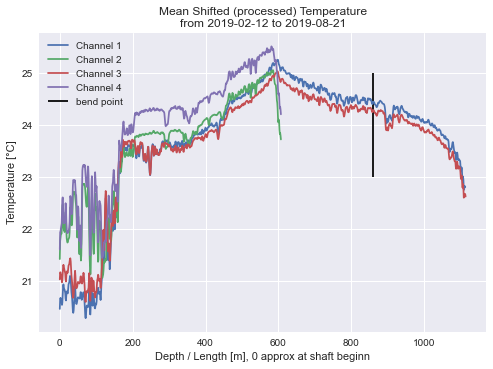

In [11]:
begin_shaft = 200 #200
data={}
for channel in ["1","2","3","4"]: 
    data[channel]=data_ch14_constshifted[channel][:15000] #[40000:48000]
last_length={}
for channel in ["1","2","3","4"]:
    last_length[channel] = data[channel][data[channel].columns[begin_shaft:]].columns.max() - begin_shaft
    print(f"Channel {channel} shifted, last length {last_length[channel]}")
bend_point=last_length["2"] + (last_length["1"] - last_length["2"]) / 2
print(f"bend point would be at {bend_point}, if assuming the DTS measurements exactly stop at the fibre break")
print("die werte  passen nicht zu S. 48 im Abschlussbericht, da war das DTS Gerät irgendwie anders angeschlossen?")

#Plot shifted data
# shaft variable only contains the data until bottom of shaft
# for chan in ["1","2","3","4"]:
#     plt.plot(shaft[chan].mean(axis=0))
for channel in ["1","2","3","4"]:
    y=data[channel][data[channel].columns[200:]].mean(axis=0).values
    x=data[channel][data[channel].columns[200:]].mean(axis=0).index - 200
    plt.plot(x,y, label=f"Channel {channel}")

plt.vlines([bend_point],23,25,color="black",label="bend point")
plt.legend()
min_date=data[channel][data[channel].columns[200:]].index.min().strftime("%Y-%m-%d")
max_date=data[channel][data[channel].columns[200:]].index.max().strftime("%Y-%m-%d")
plt.title(f"Mean Shifted (processed) Temperature\nfrom {min_date} to {max_date}")
plt.xlabel("Depth / Length [m], 0 approx at shaft beginn")
plt.ylabel("Temperature [°C]")
#plt.xlim(200,400)
plt.show()

In [12]:
c="4"
shaft_begin=200
plt_length_begin=200
data=data_ch14_constshifted[c][data_ch14_constshifted[c].columns[plt_length_begin:]][::10]
data.columns=data.columns-shaft_begin
data.columns.names=[f"Length - {shaft_begin} m"]

plot=px.imshow(data, labels={"color":"Temperature"}, title=f"Channel {c}\nTemp. over time; every date plotted",
               zmin=22,zmax=25)


#https://plotly.com/python/static-image-export/
path = r".\pictures"
# filename = "\carpet_final_temperature_EGRT-Cable_down.png"
# plot.write_image(path + filename)
#exports the plot as html, so the hover features are avaible
filename = f"\\analyse_bendpoint_ch{c}.html"
plotly.offline.plot(plot, filename=path + filename)

'.\\pictures\\analyse_bendpoint_ch4.html'

## Interpretation
* ist knick bei depth 600 realer Temperaturänderung im Schacht? Die kurzen Kabel gehen bis ca. 600. 
    * Dieser Knick ist also bei der selben Tiefe wo das Kabel gebrochen ist. (Aus der Sicht von Channel 1 und 3 ist es auf dem Weg hoch gebrochen). 
* Ist es nicht auch verwunderlich, dass nur zwei der 4 Fasern an der Stelle gebrochen sind? Die anderen werden auch in irgendeinareweise Schaden erlitten haben?!
* Bei ca. 860 geht das Kabel irgendwann wieder hoch, ist aber nicht zu sehen, eigentlich müsste es ja symmetrisch sein ab dem Punkt wo es wieder hochgeht.
* Das der Kabelbruch Punkte von vorher beeinflusst kann eigentlich nicht sein, da das Licht ja noch gar nicht bis zum Kabelbruch gekommen ist. Beschädigungen am Kabel können also nur Punkte die später kommen beeinflussen. Norbert meinte, dass sie auch vorher beieinflussen können muss ich in Literatur noch gucken.
* Bei ca. 0 (shaft begin) sieht man in den backscattered Daten eine Dämpfungsänderrung. Dort wurden Kabel gespleißt??????
* Bei 600 - 608 m sind bei der Kamerabefahrung Seile gefunden worden: ANh01 Fotot 18; Abschlussbericht S. 44
  * war die in der Pegelleitung oder im Schacht?

# Compare Channel 1-4 and Channel 5-8
Here I use the final corrected data for comparisson. The results should be "equal"

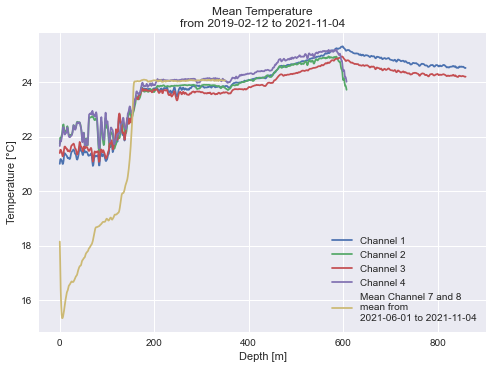

In [13]:
#both datafames have the same number of rows and dates are similar
for chan in ["1","2","3","4"]:
    plt.plot(shaft[chan].mean(axis=0).index,shaft[chan].mean(axis=0).values, label=f"Channel {chan}")

min_date=Schacht_7and8_down.index.min().strftime("%Y-%m-%d")
max_date=Schacht_7and8_down.index.max().strftime("%Y-%m-%d")
plt.plot(Schacht_7and8_down.mean(axis=0).index,Schacht_7and8_down.mean(axis=0).values, label=f"Mean Channel 7 and 8\nmean from \n{min_date} to {max_date}")
plt.legend()
min_date=shaft["2"].index.min().strftime("%Y-%m-%d")
max_date=shaft["2"].index.max().strftime("%Y-%m-%d")
plt.title(f"Mean Temperature\nfrom {min_date} to {max_date}")
plt.xlabel("Depth [m]")
plt.ylabel("Temperature [°C]")
plt.show()

In [14]:
# Calc diff to EGRT cable
channel="3"

data1 = shaft[channel]
data2 = Schacht_7and8_down
date_name, date_iloc = find_nearest_date(data2.iloc[0].name, data1.index) #find out which dates I need from data1
diff_othercable = calc_diff_between_channels(data1[date_iloc:], data2, expected_difference_minutes=15,diff_type_only_diff=False)

diff_statistic = calc_stat_of_difference(diff_othercable["diff_abs"].transpose())

# diese Berechnung könnte ich auch für jeden Channel machen, aber man sieht ja oben, dass das keinen großen Unterschied macht

# Warning später mit beschäftigen

Warning 1: large time difference
0 days 00:18:00
Warning 1: large time difference
0 days 00:18:01
Warning 1: large time difference
0 days 00:18:01


c:\Users\Mathis\Desktop\Masterthesis\Scripts_Masterarbeit\my_func_mvw\functions.py:236: RuntimeWarning:

Mean of empty slice

C:\Users\Mathis\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning:

Degrees of freedom <= 0 for slice.



In [15]:
#px.imshow(diff_othercable["diff"],zmin=-2,zmax=2)

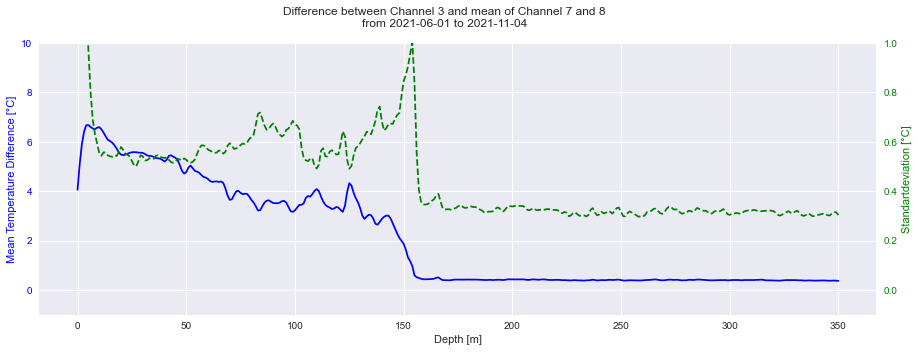

In [16]:
# Plot difference
##########Inputs##########
ymin=-1;ymax=10
cmean="blue";cstdev="green"
lstyle_mean="-";lstyle_stdev="--"
######################
fig,axs=plt.subplots(1,1,figsize=[15,5])#,constrained_layout=True)
min_date=diff_othercable["diff_abs"].columns.min().strftime("%Y-%m-%d")
max_date=diff_othercable["diff_abs"].columns.max().strftime("%Y-%m-%d")
fig.suptitle(f"Difference between Channel {channel} and mean of Channel 7 and 8\nfrom {min_date} to {max_date}")
#fig.tight_layout()

axs.plot(diff_statistic.loc["mean"].index,diff_statistic.loc["mean"].values,label="mean",color=cmean,linestyle=lstyle_mean)#label="Bottom Hole Temperature"
axs.set_xlabel("Depth [m]")
axs.set_ylabel("Mean Temperature Difference [°C]",color=cmean)
axs.set_ylim(ymin,ymax) # both y-axis have similar scale --> helper lines are alligned
axs.tick_params(axis='y', labelcolor=cmean)

axs0_2 = axs.twinx()
axs0_2.plot(diff_statistic.loc["stdev"].index,diff_statistic.loc["stdev"].values,label="stdev",color=cstdev,linestyle=lstyle_stdev) #,label="Salinity")
axs0_2.set_ylabel('Standartdeviation [°C]', color=cstdev)
axs0_2.set_ylim(ymin/10,ymax/10) # both y-axis have similar scale --> helper lines are alligned
axs0_2.tick_params(axis='y', labelcolor=cstdev)
# The grids are not alligned, if not using .set_ylim()
axs0_2.grid(None) #axs is behind the helper lines
plt.show()


* Im Wasser sind sich die Ergebnisse sehr ähnlich. Vorher nicht.
* Die ersten 151.6 m gehen Channel 1-4 durch eine Bohrung im Beton. 
* Channel 5-8 gehen die durch ein anderes Rohr, eine Pegelleitung

7234 dates with nan have been added


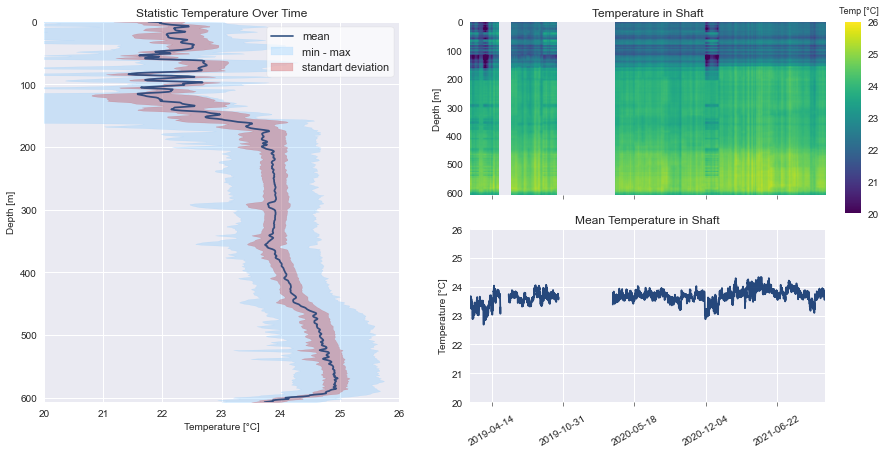

In [17]:
channel="2"
statistic_plot(data_shaft=shaft,date_min_max=[0,-1],c=channel,temp_ax_min=20, temp_ax_max=26, sample_hours = 6)
if plot_save and channel == "2":
    filename=f"\\temperature_in_shaft_chan{channel}_statistic"
    plt.savefig(r".\pictures" + filename + ".png", bbox_inches="tight")
    plt.savefig(r"..\Masterthesis_tex\figs\chap4" + filename + ".pdf", format="pdf",bbox_inches="tight")
plt.show()

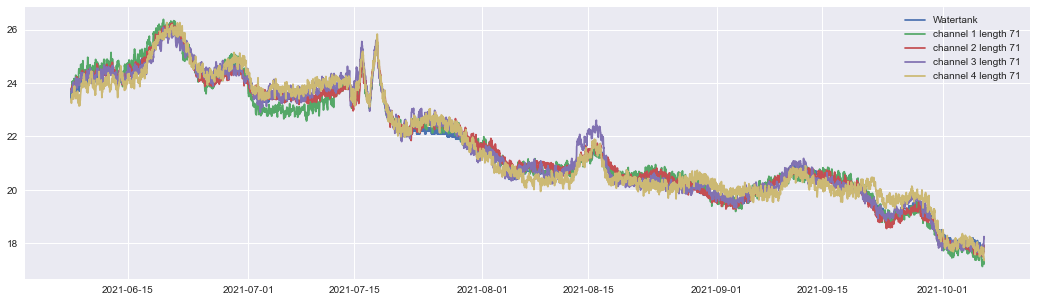

In [18]:
# Compare watertank to channels
# to find where the watertank position is
watertank = 71 

plt.figure(figsize=(18,5))
plt.plot(df_Tlogger_PT100.index, df_Tlogger_PT100["Channel1-Watertank_PT100"], label="Watertank")
#plt.plot(df_Tlogger.index, df_Tlogger["Channel2-Air"], label="Air")
for c in ["1","2","3","4"]: 
    inde=data_ch14_constshifted[c][str(df_Tlogger_PT100.index.min()) : str(df_Tlogger_PT100.index.max())][watertank].index
    val=data_ch14_constshifted[c][str(df_Tlogger_PT100.index.min()) : str(df_Tlogger_PT100.index.max())][watertank].values
    plt.plot(inde,val, label=f"channel {c} length {watertank}")

plt.legend()
plt.show()

# Compare Varianz of raw and constshift data
``compare_cg14_to_heatexchanger_usage.ipynb`` directly compares the heat exchnager usage and the data

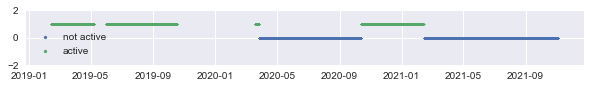

In [19]:
#erstmal ganz grob wenn ich alle daten hab mit find date function arbeiten
# evntl auch nur Bereiche mit besimmten mindestes Nutzung nehmen

# these vales are always outside the active phase
#tab for not active: first activ phase 0 to 20215
active_border=[0,21000,    39000,50000]

data_ch14_constshifted_heatpump_active = {}
for chan in ["1","2","3","4"]:
    index1=data_ch14_constshifted[chan].index[:active_border[1]]
    index2=data_ch14_constshifted[chan].index[active_border[2]+1:active_border[3]]
    index_heatpumpactive=index1.append(index2)
    data_ch14_constshifted_heatpump_active[chan] = data_ch14_constshifted[chan].loc[index_heatpumpactive]
index_heatpumpactive

data_ch14_constshifted_heatpump_notactive = {}
for chan in ["1","2","3","4"]:
    index1=data_ch14_constshifted[chan].index[active_border[1]:active_border[2]+1]
    index2=data_ch14_constshifted[chan].index[active_border[3]:]
    index_heatpumpnotactive=index1.append(index2)
    data_ch14_constshifted_heatpump_notactive[chan] = data_ch14_constshifted[chan].loc[index_heatpumpnotactive]
index_heatpumpnotactive


plt.figure(figsize=(10,1))
plt.ylim(-2,2)
plt.scatter(index_heatpumpnotactive,np.zeros(len(index_heatpumpnotactive)),s=1,label="not active")
plt.scatter(index_heatpumpactive,np.ones(len(index_heatpumpactive)),s=1, label="active")
legend=plt.legend()
for handle in legend.legendHandles:
    handle.set_sizes([9])
plt.show()

In [20]:
def calc_statistic_of_channel_difference(data):
    """"""
    df_reindex={}
    df_reindex["1"]=data["1"]
    for chan in ["2","3","4"]:
        df_reindex[chan]=data[chan].set_index(data["1"].index)

    diff={}
    mean={}
    std={}
    for chan_diff_pair in [["1","2"],["1","3"],["1","4"],["2","3"],["2","4"],["3","4"]]:
        chanx=chan_diff_pair[0]
        chany=chan_diff_pair[1]
        diff[f"{chanx} - {chany}"]=df_reindex[chanx] - df_reindex[chany]
        mean[f"{chanx} - {chany}"]=diff[f"{chanx} - {chany}"].mean(axis=0) #mean along columns (length)
        std[f"{chanx} - {chany}"]=diff[f"{chanx} - {chany}"].std(axis=0)

    number_dates_used = len(diff[f"{chanx} - {chany}"].index)

    mean["all"]=pd.concat([mean[x] for x in mean.keys()], axis=1).mean(axis=1) # mean of all differences 
    std["all"]=pd.concat([std[x] for x in std.keys()], axis=1).mean(axis=1) # mean standart deviation of all differences
    return mean, std, number_dates_used

print("mean_constshift")
mean_constshift, std_constshift, number_dates_used = calc_statistic_of_channel_difference(data_ch14_constshifted)
# print("mean_raw") #does not show anything new
# mean_raw, std_raw, number_dates_used_raw = calc_statistic_of_channel_difference(data_ch14_processed_withoutTlogger) #variable not in this script
print("mean_constshift_heatpumpactive")
mean_constshift_heatpumpactive, std_constshift_heatpumpactive, number_dates_used_heatpumpactive = calc_statistic_of_channel_difference(data_ch14_constshifted_heatpump_active)
print("mean_constshift_heatupumnotactive")
mean_constshift_heatpumpnotactive, std_constshift_heatpumpnotactive, number_dates_used_heatpumpnotactive = calc_statistic_of_channel_difference(data_ch14_constshifted_heatpump_notactive)

mean_constshift
mean_constshift_heatpumpactive
mean_constshift_heatupumnotactive


In [21]:
# Peaks are at month 05 even when heat exchanger is off

# data1=data_all_processed_constshifted_heatpump_notactive["2"]
# col=data1.columns
# data2=data_all_processed_constshifted_heatpump_notactive["3"][col]
# testdiff=data1.set_index(data2.index)-data2
# col=testdiff.columns[300:]
# testdiff[col].mean(axis=1).plot()
# plt.ylim(-0.5,2)
# plt.show()

# data1=data_all_processed_constshifted_heatpump_notactive["2"]
# col=data1.columns
# data2=data_all_processed_constshifted_heatpump_notactive["3"][col]
# testdiff=data1.set_index(data2.index)-data2
# col=testdiff.columns[80:150]
# testdiff[col].mean(axis=1).plot()
# plt.ylim(-0.5,2)
# plt.show()

all dates


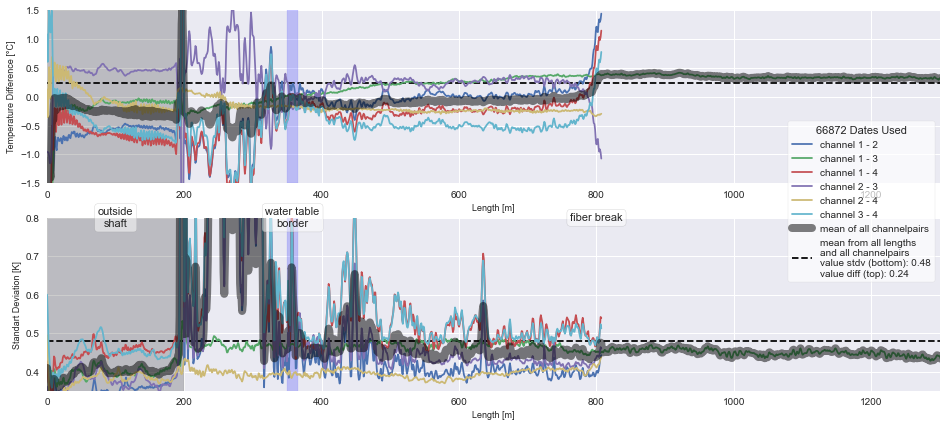

heatpump not active


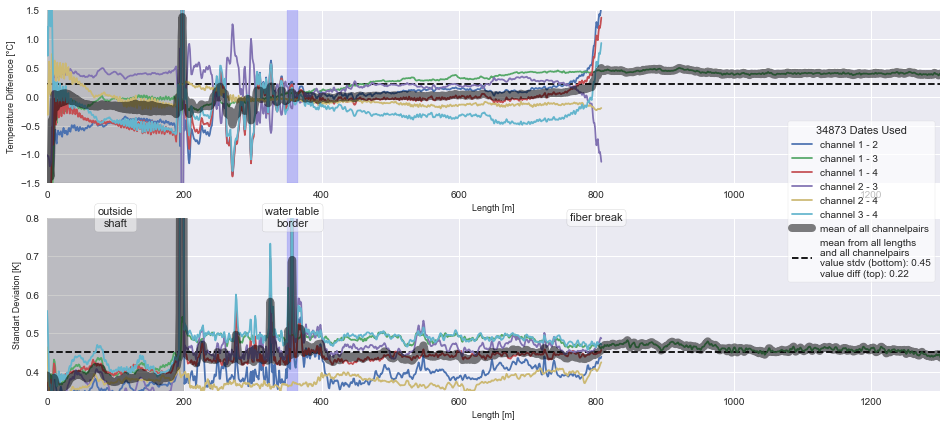

heatpump active


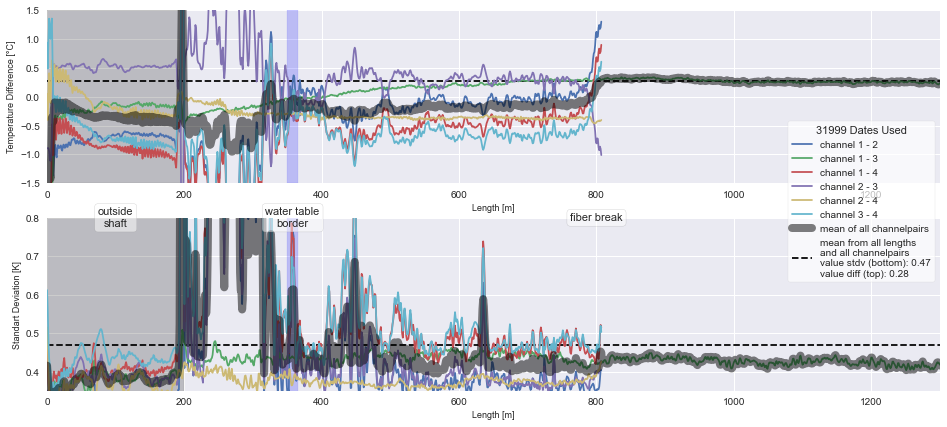

In [22]:
def plot_statistic_of_channel_difference(mean, std, number_dates_used_string, ylim=[-1.5,1.5], ax1ylim=[0.35,0.8],diff_plot=False):
    fig, axs=plt.subplots(2,1,figsize=[16,7])
    for chan_diff_pair in [["1","2"],["1","3"],["1","4"],["2","3"],["2","4"],["3","4"]]:
        chanx=chan_diff_pair[0]
        chany=chan_diff_pair[1]
        axs[0].plot(mean[f"{chanx} - {chany}"], label=f"channel {chanx} - {chany}")
        axs[1].plot(std[f"{chanx} - {chany}"], label=f"channel {chanx} - {chany}")
    axs[0].plot(mean["all"], label="mean of all channelpairs", linewidth=8, alpha=0.5, color="black")
    if diff_plot==False:
        hline_value_diff=round(abs(mean["all"]).mean(),2)
        axs[0].hlines([hline_value_diff],mean["all"].index.min(),mean["all"].index.max(), 
                    #label=f"mean from absolute values of\nall lengths\nand all channelpairs\nvalue: {hline_value_diff}", 
                    color="black", linestyle="--")
    axs[1].plot(std["all"], label="mean of all channelpairs", linewidth=8, alpha=0.5, color="black")
    if diff_plot==False:
        hline_val_stdv=round(std["all"].mean(),2)
        axs[1].hlines([hline_val_stdv],std["all"].index.min(),std["all"].index.max(),
                    label=f"mean from all lengths\nand all channelpairs\nvalue stdv (bottom): {hline_val_stdv}\nvalue diff (top): {hline_value_diff}", 
                    color="black", linestyle="--")
    

    # Assecoirs
    def color_cable_pos(start_len, end_len, col, ymax, ymin, label_name, axs, label=True):
        """ creates patches which color the plot"""
        width = end_len - start_len
        Rectangle=patches.Rectangle(xy=[start_len,ymin],width=width,height=(ymax-ymin),color=col,alpha=0.2)
        axs.add_patch(Rectangle)
        if label:
            #axs.annotate(label_name,[start_len+width/2, ymax-(ymax-ymin)*0.9],size=15)
            bbox_props=dict(boxstyle="round",fc="white", ec="0.5", alpha=0.5)
            axs.text(start_len+width/2,ax1ylim[1],label_name,ha="center",va="center",size=11,bbox=bbox_props)

    axs[0].set_ylim(ylim)
    axs[0].set_xlim(0,1300)
    axs[0].set_xlabel("Length [m]",fontsize=9)
    axs[0].set_ylabel("Temperature Difference [°C]",fontsize=9)

    color_cable_pos(0,200,"black",ylim[1],ylim[0],"outside\nshaft",axs[0],label=False)
    color_cable_pos(0,200,"black",ylim[1],ylim[0],"outside\nshaft",axs[1])
    color_cable_pos(350,365,"blue",ylim[1],ylim[0],"water table\nborder",axs[0],label=False)
    color_cable_pos(350,365,"blue",ylim[1],ylim[0],"water table\nborder",axs[1])
    bbox_props=dict(boxstyle="round",fc="white", ec="0.5", alpha=0.5)
    axs[1].text(800,ax1ylim[1],"fiber break",ha="center",va="center",size=11,bbox=bbox_props)

    axs[1].set_ylim(ax1ylim)
    axs[1].set_xlim(0,1300)
    axs[1].set_xlabel("Length [m]",fontsize=9)
    axs[1].set_ylabel("Standart Deviation [K]",fontsize=9)

    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    by_label = dict(zip(labels, lines))
    legend=fig.legend(by_label.values(), by_label.keys(),fontsize=10,ncol=1, frameon=True,loc="right",bbox_to_anchor=[0.9,0.5],
                        title=f"{number_dates_used_string}",title_fontsize=11)
    legend.get_frame().set_alpha(0.7) #not supported with eps
    legend.get_frame().set_facecolor("white")

print("all dates")
plot_statistic_of_channel_difference(mean_constshift, std_constshift, f"{number_dates_used} Dates Used")
if plot_save:
    plt.savefig(r"..\Masterthesis_tex\figs\chap4\statistics_differences_constshift_ch1-4.pdf", format="pdf",bbox_inches="tight")
    plt.savefig(r".\pictures\statistics_differences_constshift_ch1-4.png",bbox_inches="tight")
plt.show()

print("heatpump not active")
plot_statistic_of_channel_difference(mean_constshift_heatpumpnotactive, std_constshift_heatpumpnotactive,f"{number_dates_used_heatpumpnotactive} Dates Used")
if plot_save:
    plt.savefig(r"..\Masterthesis_tex\figs\chap4\statistics_differences_constshift_heatpumpnotactive_ch1-4.pdf", format="pdf",bbox_inches="tight")
    plt.savefig(r".\pictures\statistics_differences_constshift_heatpumpnotactive_ch1-4.png",bbox_inches="tight")
plt.show()

print("heatpump active")
plot_statistic_of_channel_difference(mean_constshift_heatpumpactive, std_constshift_heatpumpactive, f"{number_dates_used_heatpumpactive} Dates Used")
if plot_save:
    plt.savefig(r"..\Masterthesis_tex\figs\chap4\statistics_differences_constshift_heatpumpactive_ch1-4.pdf", format="pdf",bbox_inches="tight")
    plt.savefig(r".\pictures\statistics_differences_constshift_heatpumpactive_ch1-4.png",bbox_inches="tight")
plt.show()


standard deviations heatpumpnotactive
1 - 2: 0.39684453567471795
1 - 3: 0.4701167075999632
1 - 4: 0.44019746506302637
2 - 3: 0.46464416690945864
2 - 4: 0.3812505163195311
3 - 4: 0.4863391126565867
all: 0.4514900127580888



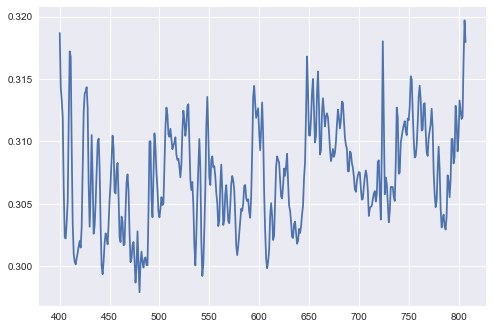

In [23]:
print("standard deviations heatpumpnotactive")
for key in std_constshift_heatpumpnotactive.keys():
    m=std_constshift_heatpumpnotactive[key][395:].mean() #mean stdv in shaft water ehat pump not active
    print(f"{key}: {m}")
print()

data_ch14_constshifted_heatpump_notactive["4"].std(axis=0)[400:].plot()
plt.show()

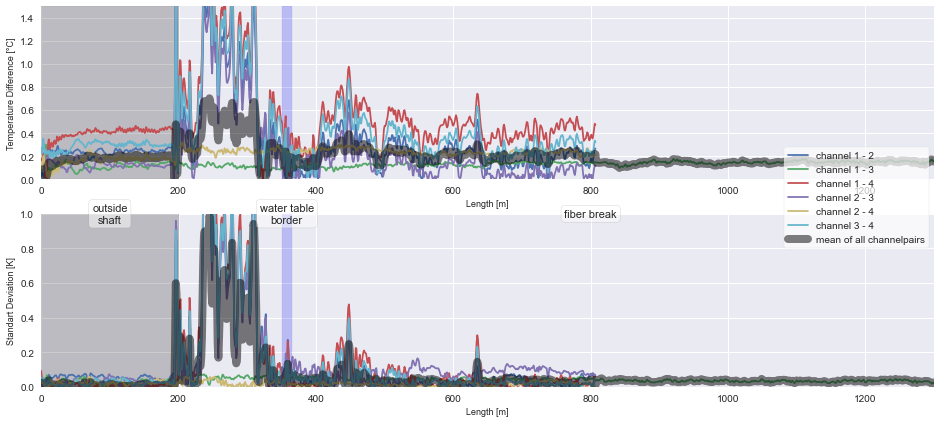

In [24]:
# difference between figures of heatpum active and not active
mean_diff={}
std_diff={}
for chanpairkey in mean_constshift_heatpumpnotactive.keys():
    mean_diff[chanpairkey]=abs(mean_constshift_heatpumpnotactive[chanpairkey] - mean_constshift_heatpumpactive[chanpairkey])
    std_diff[chanpairkey]=abs(std_constshift_heatpumpnotactive[chanpairkey] - std_constshift_heatpumpactive[chanpairkey])

plot_statistic_of_channel_difference(mean_diff, std_diff, "" ,ylim=[0,1.5], ax1ylim=[0,1],diff_plot=True)

if plot_save:
    plt.savefig(r"..\Masterthesis_tex\appendix\statistics_differences_constshift_diff_activenotactive_ch1-4.pdf", format="pdf",bbox_inches="tight")
    plt.savefig(r".\pictures\statistics_differences_constshift_diff_activenotactive_ch1-4.png",bbox_inches="tight")
plt.show()

# Does not show anything new
# plot_statistic_of_channel_difference(mean_raw, std_raw, ylim=[-4,4])
# if plot_save:
#     plt.savefig(r"..\Masterthesis_tex\figs\chap4\statistics_differences_raw_ch1-4.pdf", format="pdf",bbox_inches="tight")
#     plt.savefig(r".\pictures\statistics_differences_raw_ch1-4.png",bbox_inches="tight")
# plt.show()

In [33]:
# Resample data
channel="2"
resample_hours=12
col=shaft[channel].columns[145:170]
resample_data=shaft[channel][col].resample(f"{resample_hours}H").mean()#[1720:] #use with show_additional_water_level_info=False in plot function
#[1720:] can be used to get a better comparisson with channels 5 to 8

# so both plots have same shape in thesis
col=resample_data.columns[4:]

plot_water_rise(resample_data[col],linear_curve=[163.3,0.008],plot_save=plot_save,show_additional_water_level_info=True)

fitted water level rise: 2.9 m / year
this is a total of 8.0 m in the measurement time


# Shaft water monitoring

In [34]:
# Calc diff and determine linear curve at that plot
all_diff_columns=[]
number_of_averages=1
for x in resample_data.columns[:-number_of_averages*2]:
    noa=number_of_averages
    x_index=x-resample_data.columns[0]
    col1=resample_data.columns[x_index:x_index+noa]
    col2=resample_data.columns[x_index+noa:x_index+2*noa]
    diff_colum=resample_data[col2].mean(axis=1) - resample_data[col1].mean(axis=1)
    #diff_colum=resample_data[x] - resample_data[x+1]

    all_diff_columns.append(diff_colum)

df_diff=pd.concat(all_diff_columns,axis=1)
df_diff.columns=resample_data.columns[:-number_of_averages*2]+number_of_averages+0.5
df_diff=round(df_diff,1)

# Plot and save
plot_water_rise(df_diff,plot_save=plot_save,linear_curve=[163.3,0.008],title="Diff.",zminmax=[0,0.5],show_additional_water_level_info=True)

fitted water level rise: 2.9 m / year
this is a total of 8.0 m in the measurement time


In [27]:
# Calc slope of the data to make more difference more visible
# than determine linear curve at that plot
# bad results, above plot with differences is better

# from scipy.stats import linregress
# import math

# all_dates=[]
# all_dates_date=[]
# depth_for_slope_calc=4
# for loc in resample_data.index:
#     slopes_date=[]
#     depth_corresponding_slope=[]
#     for x in resample_data.columns[0:-depth_for_slope_calc]:
#         x_index=x-resample_data.columns[0]
#         slope, intercept, r_value, p_value, std_err = linregress(resample_data.loc[loc][x_index:x_index+depth_for_slope_calc], resample_data.columns[x_index:x_index+depth_for_slope_calc])
#         slopes_date.append(slope)
#         depth_corresponding_slope.append(math.trunc(x+depth_for_slope_calc/2))
#         # print(x)
#         # print(math.trunc(x+depth_for_slope_calc/2))

#     all_dates.append(slopes_date)
#     all_dates_date.append(loc)
#     #depth_corresponding_slope# check if it is equal for all dates
#     # plt.scatter(depth_corresponding_slope,slopes_date)
#     # plt.show()

# df=pd.DataFrame(all_dates,index=all_dates_date,columns=depth_corresponding_slope)
# df=round(df,2)
# px.imshow(df.transpose(),zmin=-5,zmax=5)

In [28]:
# Try to find a function which describes shaft water rise with data from rosner2011
# bad results
show_interpolation=False 
if show_interpolation:
    # Compare linear and quadrtatic increase of water level

    alph=0.4 #for some curves
    # normal time range for plotting
    # x_data=datetonum
    # very large time range for plotting
    start=pd.to_datetime("01.01.1990")
    end=pd.to_datetime("01.01.2050")
    x_large=mdates.date2num(pd.date_range(start,end,freq="M"))
    fig,axs=plt.subplots(1,1,figsize=(16,5))

    #Quadratic fit
    first_date=pd.to_datetime("1994-01-01")
    last_date=pd.to_datetime("2022-01-01")
    dates=pd.date_range(first_date,last_date,freq="D")
    datetonum=mdates.date2num(dates)
    a=0.000006 #0.000005
    h=datetonum[-1] #last_date
    k=155 # y position of final water level
    print("Annahme Scheitelpunkt is am last_date erreicht erreicht, für manual fit")
    x=datetonum-datetonum[0]
    ground_water_depth_fit_quadratic=a*(x-h)**2+k
    x=x_large
    axs.plot(x,a*(x-h)**2+k,label="quadratic fit manual",linestyle="--",alpha=alph) 

    #linear fit
    datetonum_linear=mdates.date2num(df_diff.index)
    x=datetonum_linear-datetonum_linear[0]
    ground_water_depth_fit_linear=-0.008*x+163
    axs.plot(datetonum_linear,ground_water_depth_fit_linear,label="linear fit from DTS",linewidth=9)

    # scatter measured data
    dates_scat=["01.01.1995","01.05.1998","01.01.2002","04.12.2003","01.01.2005","01.01.2009","24.11.2020"]
    #"04.12.2003" wireline log 2003
    #"24.11.2020" wireline log 2020
    #Rest von rosner 2011 abgeschätzt aus Abbildung
    depth_scat=[860,610,460,392,360,252,158]
    axs.scatter(pd.to_datetime(dates_scat),depth_scat,label="measured water level?",zorder=10)

    # fitted quadratic function from scatter data
    datetonum_q_fit=mdates.date2num(pd.to_datetime(dates_scat))
    x=datetonum_q_fit
    poly=np.polyfit(x[1:],depth_scat[1:],2)
    x=x_large
    axs.plot(x,poly[2]+ x*poly[1]+x**2*poly[0],label="fitted quadratic from scatter points\nneglet oldest point",linestyle="--",alpha=alph)
    x=datetonum_q_fit
    poly=np.polyfit(x,depth_scat,2)
    x=x_large
    axs.plot(x,poly[2]+ x*poly[1]+x**2*poly[0],label="fitted quadratic from scatter points",linestyle="--",alpha=alph)

    #fitted quadratic from linear and wireline logs
    x_dates=pd.to_datetime([pd.to_datetime("04.12.2003")]).union(np.array(df_diff.index[::400]))
    datetonum_linearploly=mdates.date2num(x_dates)
    poly=np.polyfit(datetonum_linearploly,np.append(392,ground_water_depth_fit_linear[::400]),2)
    x=x_large
    axs.plot(x,poly[2]+ x*poly[1]+x**2*poly[0],label="fitted quadratic from linear and wireline 2003 scatter point",linestyle="--",alpha=alph)

    datetonum_linearploly=mdates.date2num(df_diff.index[::400])
    poly=np.polyfit(datetonum_linearploly,ground_water_depth_fit_linear[::400],2)
    x=x_large
    axs.plot(x,poly[2]+ x*poly[1]+x**2*poly[0],label="fitted quadratic, only from linear",linestyle="--",alpha=alph)

    # fit an asymtotic function
    def asy_function(x, a,b):
        """asympotic function"""
        return a+b/x
    from scipy.optimize import curve_fit
    # # fit only with scattered data
    # popt, pcov = curve_fit(asy_function, datetonum_q_fit, depth_scat)
    # add some data of linear curve to fit
    datetonum_asyploly=mdates.date2num(df_diff.index[::400]).tolist()
    all_datetonum_i_want=datetonum_asyploly+datetonum_q_fit.tolist()[2:] #scip oldest points
    all_depths_I_want=ground_water_depth_fit_linear[::400].tolist()+depth_scat[2:]
    popt, pcov = curve_fit(asy_function, all_datetonum_i_want, all_depths_I_want)
    x=x_large
    axs.plot(x,asy_function(x,popt[0],popt[1]),label=f"asymptotic fit to scattered and linear data\nasymtope: {round(popt[0],1)} m",linestyle="--",alpha=alph)

    # # semi manuall fitted asymptote, does not give good resutls
    # # also tried looping over different asymptote constants
    # def asy_function_semi_fit(x ,b):
    #     """asympotic function"""
    #     asy_const=130
    #     return asy_const+b/x
    # popt, pcov = curve_fit(asy_function_semi_fit, all_datetonum_i_want, all_depths_I_want)
    # axs.plot(x,asy_function_semi_fit(x,popt[0]),label=f"asymptotic semi fit to scattered and linear data")#),linestyle="--",alpha=alph)

    #e-function fit #cant find optimal parameters
    # def e_function(x, a,b): 
    #     """asympotic function"""
    #     return a*np.e**(x+b)


    axs.set_ylim(100,800)
    axs.invert_yaxis()
    axs.legend()
    plt.show()